In [12]:
import numpy as np
import sys
sys.path.append('modules/')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ChromDynamics import MiChroM
from CndbTools import cndbTools
cndbT=cndbTools()
import logging
import os
import shutil
from scipy.optimize import curve_fit


In [2]:

logging.basicConfig(level=logging.info, format="%(asctime)s - %(levelname)s - %(message)s")

logging.debug("Debug message (useful for troubleshooting)")
logging.info("Info message (general information)")
logging.warning("Warning message (something is not right)")
logging.error("Error message (something failed)")
logging.critical("Critical message (serious error)")

TypeError: Level not an integer or a valid string: <function info at 0x105094360>

In [18]:

def initialize_simulation(name='sim', N=1000, platform='None', collapse=True, nblocks_collapse=10, blocksize_collapse=10000, save_folder='output', chi=-0.1, ka=1.0, Ecut=4.0):
    #simulate
    sim = MiChroM(name=name,temperature=1.0, time_step=0.01, collision_rate=0.1)

    if platform=="None":
        platform_setup = False
        for platform in ["CUDA", "OPENCL","HIP", "CPU"]:
            try:
                sim.setup(platform=platform)
                platform_setup = True
                print(f"Selected platform: {platform}")
                break
            except: pass
            
        assert platform_setup, "No platform could be found!"
    else:
        sim.setup(platform=platform)
        print(f"Selected platform: {platform}")
    
    sim.setup(platform=platform)
    sim.saveFolder(save_folder)
    gen_seq(N)
    # mychro = sim.createRandomWalk(ChromSeq=os.path.join(args.home,f"input/exp_seq_{args.rep_frac}.txt"))#, isRing=True)
    init_struct = sim.createRandomGas(ChromSeq='input/seq.txt')#, isRing=True)
    sim.loadStructure(init_struct, center=True)

    #add potentials
    # sim.addFENEBonds(kfb=30.0)
    sim.addHarmonicBonds(kfb=100.0,r0=1.0)
    # sim.addAngles(ka=ka)
    sim.addHarmonicRestraintAngles(k_angle=ka, )
    # sim.addNextNearestNeighborHarmonicBonds(kfb=ka, r0=2.5)
    sim.addSelfAvoidance(Ecut=Ecut, k_rep=5.0, r0=0.5)
    
    gen_types_table(chi)
    sim.addCustomTypes(mu=5.0, rc = 1.5, TypesTable='input/types_table.csv')
    
    # sim.addFlatBottomHarmonic(kr=0.1, n_rad=30)
    # sim.addCylindricalConfinement(r_conf=args.rconf, z_conf=args.zconf, kr=5.0)
    
    if collapse==True:
        print('Running collapse simulation')
        for _ in range(nblocks_collapse): 
            sim.runSimBlock(blocksize_collapse, increment=False)
        # sim.saveStructure(mode = 'pdb')
    
    return sim

def gen_types_table(chi):
    with open(f'./input/types_table.csv', 'w') as f:
        f.write(f'A,B\n')
        f.write(f'{chi},{chi}\n')
        f.write(f'{chi},{chi}')
        
    
def gen_seq(N):
    with open(f'./input/seq.txt', 'w') as fseq:
        for ii in range(N):
            if ii>2: bead_type='A'
            else: bead_type='B'
            fseq.write(f'{ii+1} {bead_type}\n')
            
def get_meanRG(sim, n_blocks=5000, blocksize=1000):
    sim.initStorage(filename=sim.name)
    Rg = []
    for jj in range(n_blocks):
        sim.runSimBlock(blocksize, increment=True) 
        sim.saveStructure()
        Rg.append(sim.chromRG())
    return (np.mean(Rg), np.std(Rg))
        
    # sim.storage[0].close()
    
def load_traj(traj_file,dt=2):
    print('Loading trajectory ...')
    trajec = cndbT.load(traj_file)
    xyz=cndbT.xyz(frames=range(1,trajec.Nframes,dt))
    print('Trajectory shape:', xyz.shape)
    return xyz

In [20]:
chivals = np.arange(-0.3,0.1,0.1)
Ecut = [4.0]
data = {}
kavals = [0.0, 20.0, 50.0, 200.0]
shutil.rmtree('./output')
for ka in kavals:
    for chi in chivals:
        for ecut in Ecut:
            meanvals, stdvals = [], []
            for rep in range(1):
                sim = initialize_simulation(name=f"{ka:.2f}-{chi:.2f}-{ecut:.2f}", N=1000, nblocks_collapse=1, blocksize_collapse=10000, chi=chi,ka=ka, Ecut=ecut)
                mean, std = get_meanRG(sim,n_blocks=2, blocksize=500)
                meanvals.append(mean)
                
            data[f'{ka:.2f}-{ecut:.2f}-{chi:.2f}']=(np.mean(meanvals), np.std(meanvals))
            


Selected platform: OPENCL
Running collapse simulation
Number of exceptions: 999
adding force  HarmonicBond 0
adding force  HarmonicRestraintAngleForce 1
Add exclusions for SelfAvoidance force
adding force  SelfAvoidance 2
Add exclusions for CustomTypes force
adding force  CustomTypes 3
Positions... 
 loaded!
potential energy is 246551.072000
bl=0 dr=50.04 t=100.0ps kin=3.50 pot=5.11 Rg=1.661 SPS=850 
bl=1 dr=1.06 t=105.0ps kin=3.13 pot=5.02 Rg=1.615 SPS=852 
bl=2 dr=0.84 t=110.0ps kin=2.76 pot=4.68 Rg=1.591 SPS=847 
Selected platform: OPENCL
Running collapse simulation
Number of exceptions: 999
adding force  HarmonicBond 0
adding force  HarmonicRestraintAngleForce 1
Add exclusions for SelfAvoidance force
adding force  SelfAvoidance 2
Add exclusions for CustomTypes force
adding force  CustomTypes 3
Positions... 
 loaded!
potential energy is 242000.704000
bl=0 dr=49.92 t=100.0ps kin=2.94 pot=1.03 Rg=4.944 SPS=963 
bl=1 dr=1.58 t=105.0ps kin=2.40 pot=0.62 Rg=4.796 SPS=1199 
bl=2 dr=1.49 t

Context leak detected, msgtracer returned -1


(i) dr=50.74 t=100.0ps kin=11.19 pot=15.82 Rg=8.929 SPS=946 
bl=1 (i) dr=1.57 t=105.0ps kin=5.11 pot=7.92 Rg=8.656 SPS=1183 
bl=2 dr=1.09 t=110.0ps kin=2.52 pot=5.59 Rg=8.761 SPS=1231 
Selected platform: OPENCL
Running collapse simulation
Number of exceptions: 999
adding force  HarmonicBond 0
adding force  HarmonicRestraintAngleForce 1
Add exclusions for SelfAvoidance force
adding force  SelfAvoidance 2
Add exclusions for CustomTypes force
adding force  CustomTypes 3
Positions... 
 loaded!
potential energy is 243699.616000
bl=0 (i) dr=50.87 t=100.0ps kin=16.72 pot=19.45 Rg=10.621 SPS=958 
bl=1 (i) dr=1.85 t=105.0ps kin=6.36 pot=8.82 Rg=10.376 SPS=1174 
bl=2 dr=1.21 t=110.0ps kin=2.93 pot=5.58 Rg=10.507 SPS=1029 
Selected platform: OPENCL
Running collapse simulation
Number of exceptions: 999
adding force  HarmonicBond 0
adding force  HarmonicRestraintAngleForce 1
Add exclusions for SelfAvoidance force
adding force  SelfAvoidance 2
Add exclusions for CustomTypes force
adding force  Custo

In [21]:
data.keys()

dict_keys(['0.00-4.00--0.30', '0.00-4.00--0.20', '0.00-4.00--0.10', '0.00-4.00-0.00', '20.00-4.00--0.30', '20.00-4.00--0.20', '20.00-4.00--0.10', '20.00-4.00-0.00', '50.00-4.00--0.30', '50.00-4.00--0.20', '50.00-4.00--0.10', '50.00-4.00-0.00', '200.00-4.00--0.30', '200.00-4.00--0.20', '200.00-4.00--0.10', '200.00-4.00-0.00'])

[ 0.17472776 10.02517839]


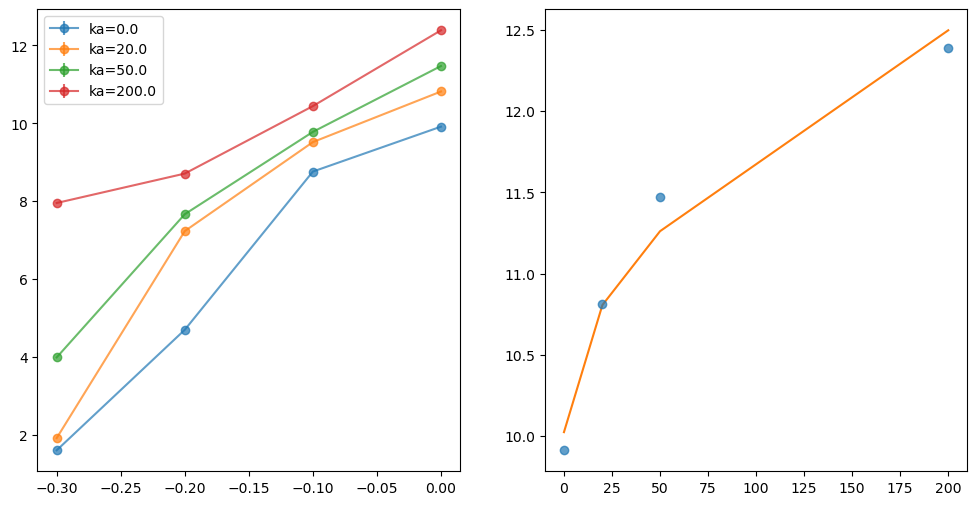

In [29]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

def fit_fn(x, a, b, c):
        return a * x ** b + c

def fit_wlc(x, a, b):
        return a * np.sqrt(x) + b

    
for ecut in Ecut:
    for ka in kavals:
    
        ax[0].errorbar(chivals,[data[f'{ka:.2f}-{ecut:.2f}-{chi:.2f}'][0] for chi in chivals],
                    yerr=[data[f'{ka:.2f}-{ecut:.2f}-{chi:.2f}'][1] for chi in chivals],label=f'ka={ka}', fmt='o-',alpha=0.7)
    
    
    ax[1].errorbar(kavals, [data[f'{ka:.2f}-{ecut:.2f}-{chi:.2f}'][0] for ka in kavals],
                   yerr=[data[f'{ka:.2f}-{ecut:.2f}-{chi:.2f}'][1] for ka in kavals],label=f'{ecut}-{chi}', fmt='o',alpha=0.7)

    popt, pcov = curve_fit(fit_wlc, kavals, [data[f'{ka:.2f}-{ecut:.2f}-{chi:.2f}'][0] for ka in kavals], p0=[1, 1])
    print(popt)
    ax[1].plot(kavals, fit_wlc(kavals, *popt), label=f'fit: {popt[0]:.2f}x^{-0.5}+{popt[1]:.2f}')
# for ecut in Ecut:
    # for chi in chivals:

ax[0].legend()
    


In [ ]:
import pickle

my_dict = {"name": "Alice", "age": 30, "is_member": True}

# Save the dictionary to a pickle file
with open("my_dict.pkl", "wb") as f:
    pickle.dump(my_dict, f)

# Load the dictionary back
with open("my_dict.pkl", "rb") as f:
    loaded_dict = pickle.load(f)

In [78]:
name='0.00-0.00-0.00'
xyz = load_traj(f'output/{name}_0.cndb',dt=1)

Loading trajectory ...
Trajectory shape: (19, 100, 3)


1


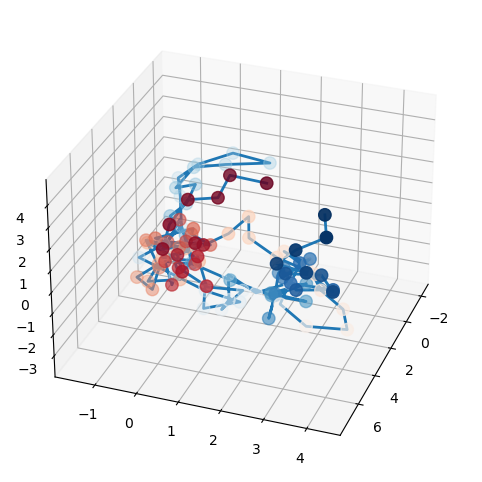

In [83]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
n=np.random.randint(0,xyz.shape[0])
print(n)
sc = ax.scatter(xyz[n,:,0], xyz[n,:,1], xyz[n,:,2], c=range(xyz.shape[1]), cmap='RdBu',s=80)
lp = ax.plot(xyz[n,:,0], xyz[n,:,1], xyz[n,:,2], lw=2)
ax.azim = 20
ax.elev = 30
# Labels

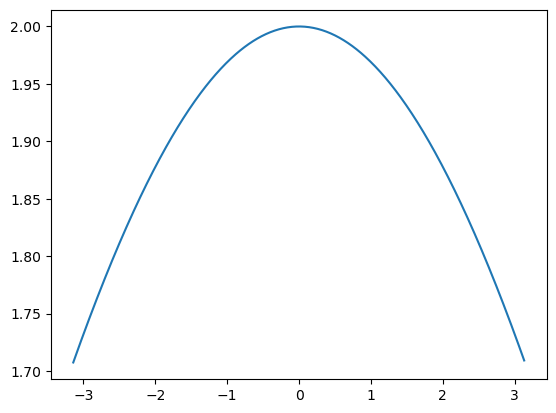

In [75]:
t=np.arange(-3.14,3.14,0.01)
plt.plot(t,(1 - np.cos(t - np.pi)))